# Customer outflow

Customers began to leave Beta Bank. Every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are presented with historical data on the behavior of customers and the termination of contracts with the bank.

Build a model with an extremely large value of *F1*-measures. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1* measure on the test sample yourself.

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

### features

RowNumber - index of the row in the data

CustomerID — the unique identifier of the customer

Surname — last name

CreditScore - credit rating

Geography — country of residence

Gender - gender

Age — age

Tenure — how many years a person has been a customer of the bank

Balance — account balance

NumOfProducts — the number of bank products used by the customer

HasCrCard - availability of a credit card

IsActiveMember - client activity

EstimatedSalary — estimated salary

### Target attribute

Exited — the fact of the client's departure

In [10]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [11]:
data=pd.read_csv('Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [12]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [13]:
data.shape

(10000, 14)

Text(0.5, 1.0, 'Distribution by country')

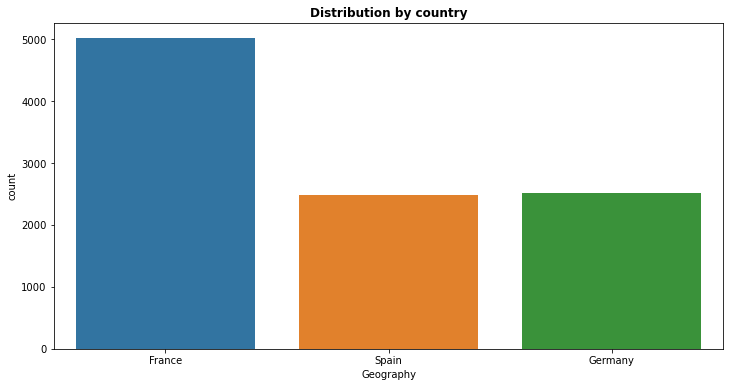

In [14]:
plt.subplots(figsize=(12,6))
sns.countplot(x=data["Geography"])
plt.title("Distribution by country", fontweight="bold")

In [15]:
data.groupby('Geography', as_index=False)[['EstimatedSalary', 'Balance']].median().sort_values('EstimatedSalary', ascending = False)

,Geography,EstimatedSalary,Balance
1,Germany,102397.22,119703.10
2,Spain,99984.86,61710.44
0,France,99132.31,62153.50


In [16]:
data.query('Exited==1').groupby('Geography', as_index=False)[['EstimatedSalary', 'Balance']].median().sort_values('EstimatedSalary', ascending = False)

,Geography,EstimatedSalary,Balance
2,Spain,108732.960,79035.95
0,France,103739.240,80376.46
1,Germany,96498.135,118951.22


In [17]:
data.query('Exited==0').groupby('Geography', as_index=False)[['EstimatedSalary', 'Balance']].median().sort_values('EstimatedSalary', ascending = False)

,Geography,EstimatedSalary,Balance
1,Germany,103557.850,120252.02
2,Spain,98768.455,0.00
0,France,98045.045,49853.57


In [18]:
data.query('Exited==0').groupby('Geography', as_index=False)[['EstimatedSalary', 'Balance']].count().sort_values('EstimatedSalary', ascending = False)

,Geography,EstimatedSalary,Balance
0,France,4204,4204
2,Spain,2064,2064
1,Germany,1695,1695


In Spain, the Balance is zero, this will obviously make a skew in the model, but we will leave

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

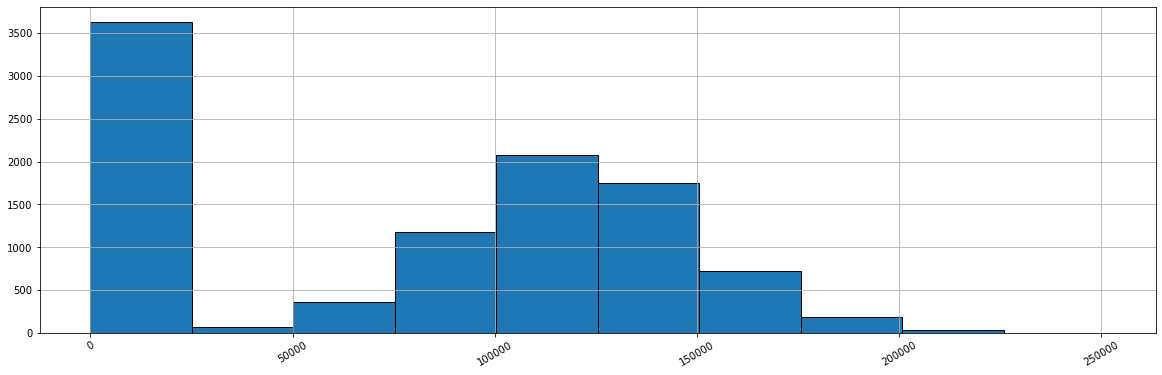

In [19]:
plt.subplots(figsize=(20,6))
plt.hist(data["Balance"], edgecolor="black")
plt.grid()
plt.xticks(rotation=30)

<AxesSubplot:>

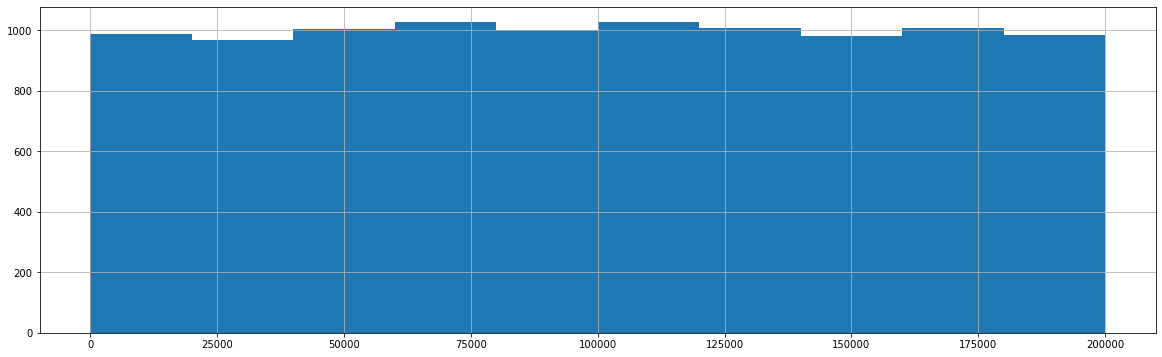

In [20]:
plt.subplots(figsize=(20,6))
data["EstimatedSalary"].hist()

<AxesSubplot:>

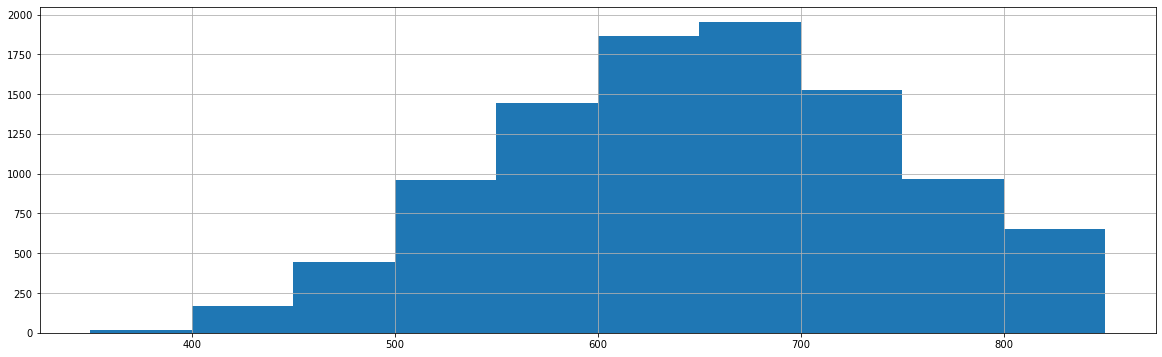

In [21]:
plt.subplots(figsize=(20,6))
data["CreditScore"].hist()

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Радует, что распределения были визуализированы.
</div>

In [22]:
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Text(0.5, 1.0, "Distribution of the client's life span")

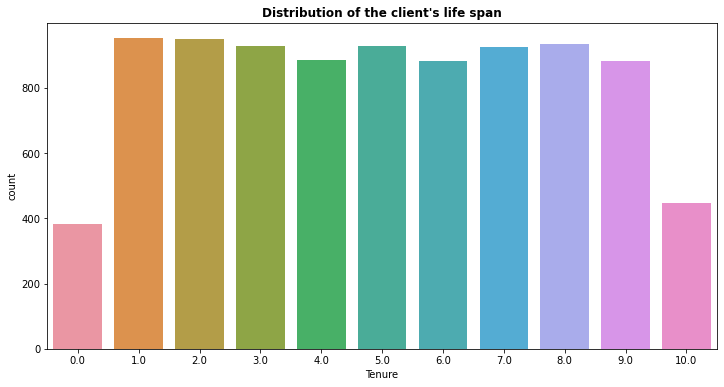

In [23]:
plt.subplots(figsize=(12,6))
sns.countplot(x=data["Tenure"])
plt.title("Distribution of the client's life span", fontweight="bold")

We can assume that if the value in the column is NAN, then there is no data about the client and it is possible - this is an assumption, there were no bank customers before, so we will replace it with zero

In [24]:
data['Tenure'] = data['Tenure'].fillna(0)
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

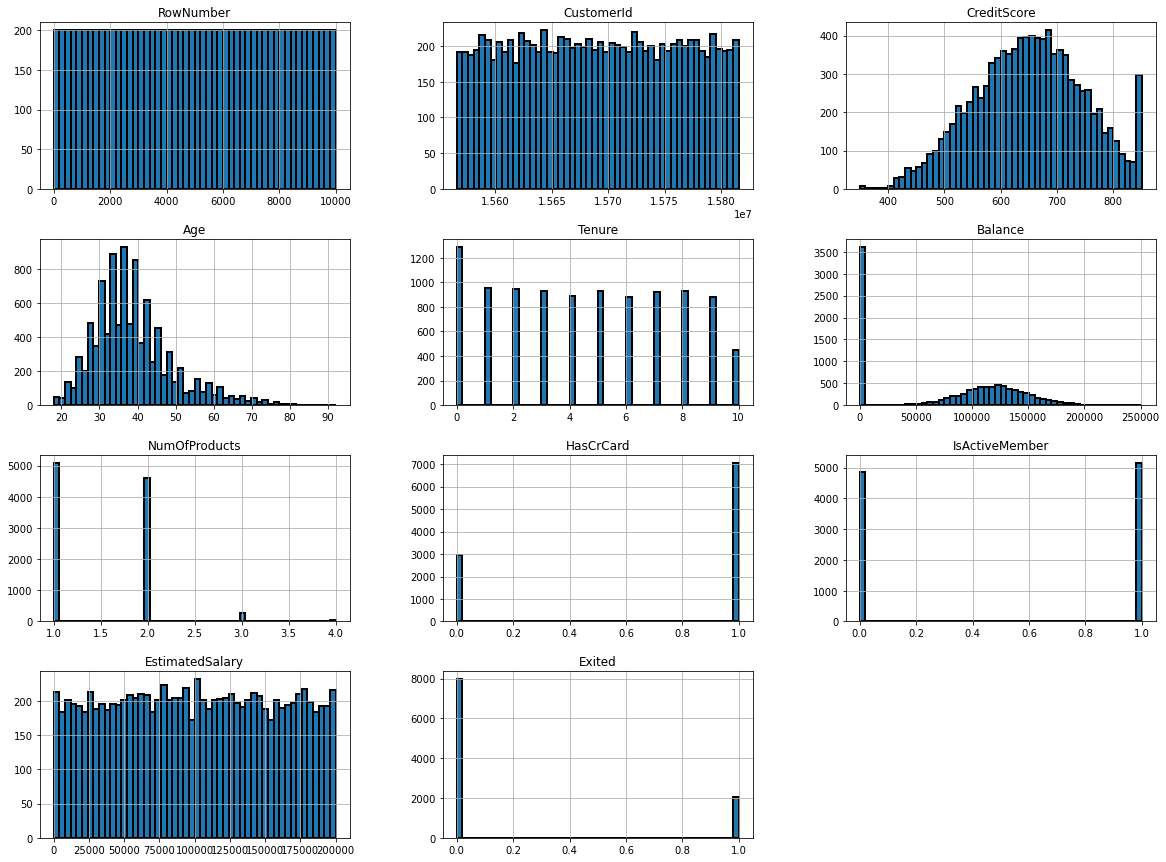

In [25]:
data.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

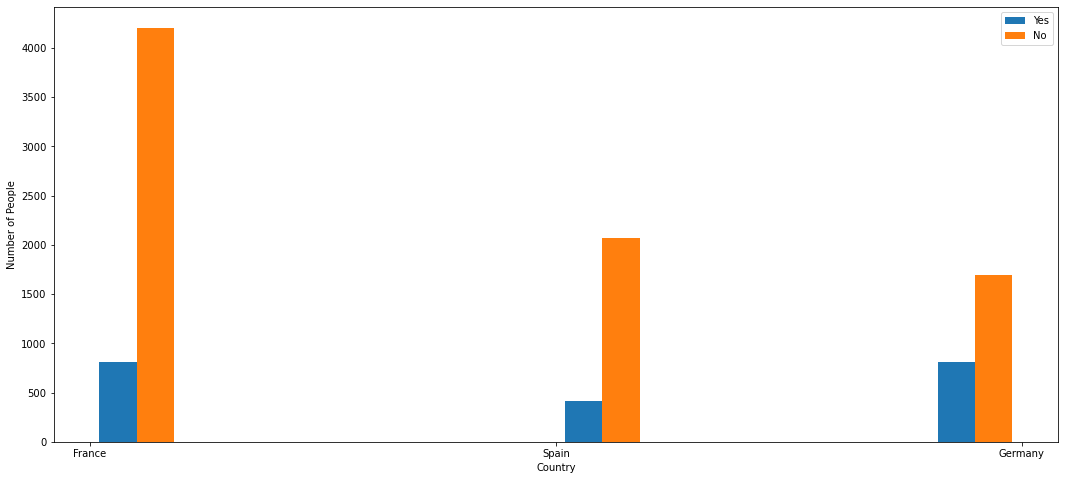

In [26]:
plt.subplots(figsize=(18,8))
plt.hist([data.query('Exited==1').Geography,data.query('Exited==0').Geography],label=("Yes","No"))
plt.xlabel("Country")
plt.ylabel("Number of People")
plt.legend()

The Surname attribute is not important to us, RowNumber, CustomerID reference information, so I'm removing it, Geography and Gender are important to us, here I'll apply the encoding

In [27]:
data=data.drop(['RowNumber','Surname', 'CustomerId'],axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [28]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [29]:
data_ohe.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [30]:
df_train, df_valid = train_test_split(data_ohe, test_size=0.25, random_state=12345)

In [31]:
df_test, df_valid  = train_test_split(df_valid, train_size=0.5, random_state=12345)

In [32]:
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']
features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

In [33]:
print('features_train',features_train.shape)
print('target_train',target_train.shape)
print('features_valid',features_valid.shape)
print('target_valid',target_valid.shape)
print('features_test',features_valid.shape)
print('target_test',target_valid.shape)

features_train (7500, 11)
target_train (7500,)
features_valid (1250, 11)
target_valid (1250,)
features_test (1250, 11)
target_test (1250,)


Since we have different attributes and different value sizes, we use data standardization

In [34]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

## Task research

Using the selection method, we will look for a model that will show us the value of the F1 metric at least 0.59 in the validation sample

In [35]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

In [36]:
f1_score(target_valid,predicted_valid)

0.508833922261484

At the initial approximation, the result is unsatisfactory

In [37]:
for max_depth in range(1,10):
    dtcclassifier = DecisionTreeClassifier(random_state=12345, max_depth=max_depth) 
    dtcclassifier.fit(features_train, target_train) 
    result = f1_score(target_valid,predicted_valid) 
    print('max_depth =',max_depth,':',result)

max_depth = 1 : 0.508833922261484
max_depth = 2 : 0.508833922261484
max_depth = 3 : 0.508833922261484
max_depth = 4 : 0.508833922261484
max_depth = 5 : 0.508833922261484
max_depth = 6 : 0.508833922261484
max_depth = 7 : 0.508833922261484
max_depth = 8 : 0.508833922261484
max_depth = 9 : 0.508833922261484


In [38]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_score(target_valid,predicted_valid)

0.2936288088642659

Logistic regression showed even worse results, then we will try to raise the value above 0.5, which was shown by the decision tree model, but then we will use the random forest model as more efficient and flexible

In [39]:
scores_data= pd.DataFrame()
max_depth_values = range(1, 50)
for max_depth in max_depth_values:
    rfclassifier = RandomForestClassifier(random_state=12345,criterion='entropy', max_depth=max_depth)
    rfclassifier.fit(features_train, target_train)
    prediction_valid=rfclassifier.predict(features_valid)
    f1 = f1_score(target_valid, prediction_valid)
    
    temp_score_data=pd.DataFrame({'max_depth' : [max_depth], 'f1': [f1]})
    
    scores_data=scores_data.append(temp_score_data)

In [40]:
scores_data.sort_values('f1', ascending = False).head()

,max_depth,f1
0,20,0.570093
0,18,0.561485
0,16,0.560748
0,19,0.556075
0,29,0.552995


In [41]:
scores_data_long=pd.melt(scores_data, id_vars =['max_depth'], value_vars = ['f1'], 
                                                                           var_name ='set_type', value_name='score') 

<AxesSubplot:xlabel='max_depth', ylabel='score'>

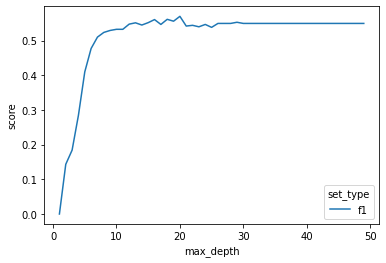

In [42]:
sns.lineplot(x='max_depth', y= 'score', hue='set_type', data=scores_data_long)

In [43]:
scores_data= pd.DataFrame()
max_est_values = range(1, 50)
for max_est in max_est_values:
    rfclassifier = RandomForestClassifier(random_state=12345,criterion='entropy', n_estimators=max_est)
    rfclassifier.fit(features_train, target_train)
    prediction_valid=rfclassifier.predict(features_valid)
    f1 = f1_score(target_valid, prediction_valid)
    
    temp_score_data=pd.DataFrame({'max_est' : [max_est], 'f1': [f1]})
    
    scores_data=scores_data.append(temp_score_data)

In [44]:
scores_data.sort_values('f1', ascending = False).head()

,max_est,f1
0,47,0.564815
0,43,0.564220
0,45,0.562212
0,49,0.558891
0,44,0.558891


<AxesSubplot:xlabel='max_est', ylabel='score'>

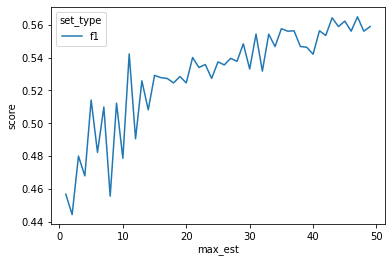

In [45]:
scores_data_long=pd.melt(scores_data, id_vars =['max_est'], value_vars = ['f1'], 
                                                                           var_name ='set_type', value_name='score') 
sns.lineplot(x='max_est', y= 'score', hue='set_type', data=scores_data_long)

In [46]:
scores_data= pd.DataFrame()
max_est_values = range(1, 30)
max_depth_values = range(1, 30)
for max_est in max_est_values:
    for max_depth in max_depth_values:
        rfclassifier = RandomForestClassifier(random_state=12345,criterion='entropy', n_estimators=max_est,max_depth=max_depth)
        rfclassifier.fit(features_train, target_train)
        prediction_valid=rfclassifier.predict(features_valid)
        f1 = f1_score(target_valid, prediction_valid)
        temp_score_data=pd.DataFrame({'max_est' : [max_est], 'max_depth' : [max_depth],'f1': [f1]})
        scores_data=scores_data.append(temp_score_data)


In [47]:
scores_data.sort_values('f1', ascending = False).head()

,max_est,max_depth,f1
0,15,15,0.566820
0,27,19,0.564920
0,28,15,0.563380
0,18,14,0.562791
0,24,15,0.562791


## Fighting the imbalance

In [48]:
best_model = None
best_result = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
    model.fit(features_train,target_train) # обучите модель на тренировочной выборке
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)# посчитайте качество модели на валидационной выборке
    if result > best_result:
        best_model = model
        best_result = result  

print('F1', best_result)

F1 0.5560538116591929


The result is better, but unsatisfactory, let's try to choose better parameters through grid_search

In [49]:
parametrs= {'n_estimators': range (10, 31, 10),
            'criterion': ['gini', 'entropy'],
            'max_depth': range (1,13, 2),
            'min_samples_leaf': range (1,5),
            'min_samples_split': range (2,6,2)}

In [50]:
clf_rf= RandomForestClassifier(random_state=12345)
grid_search_cv_clf=GridSearchCV(clf_rf, parametrs, cv=5,scoring='f1')

In [51]:
grid_search_cv_clf.fit(features_train,target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(10, 31, 10)},
             scoring='f1')

In [52]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 20}

In [53]:
best_clf=grid_search_cv_clf.best_estimator_
predicted_valid = best_clf.predict(features_valid)
f1_score(target_valid,predicted_valid)

0.5380952380952381

In [54]:
y_pred_ = model.predict(features_train)
y_pred = []
for target in y_pred_:
    if target > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Classification report: \n", classification_report(target_valid,predicted_valid))

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       978
           1       0.76      0.42      0.54       272

    accuracy                           0.84      1250
   macro avg       0.81      0.69      0.72      1250
weighted avg       0.84      0.84      0.83      1250



Perhaps another data processing will help us

In [55]:
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']
features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

In [56]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
print(features_downsampled.shape)
print(target_downsampled.shape)

(2102, 11)
(2102,)


In [57]:
print(target_downsampled.value_counts())
print(target_train.value_counts())

1    1502
0     600
Name: Exited, dtype: int64
0    5998
1    1502
Name: Exited, dtype: int64


In [58]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Accuracy = {:.3f}, Доля = {:.3f} | F1 = {:.3f}".format(
        threshold, precision, recall, f1))
    
precision, recall, threshold = precision_recall_curve(target_valid, probabilities_one_valid)

Порог = 0.00 | Accuracy = 0.218, Доля = 1.000 | F1 = 0.357
Порог = 0.05 | Accuracy = 0.220, Доля = 1.000 | F1 = 0.361
Порог = 0.10 | Accuracy = 0.236, Доля = 0.938 | F1 = 0.377
Порог = 0.15 | Accuracy = 0.268, Доля = 0.809 | F1 = 0.403
Порог = 0.20 | Accuracy = 0.310, Доля = 0.629 | F1 = 0.415
Порог = 0.25 | Accuracy = 0.360, Доля = 0.489 | F1 = 0.415
Порог = 0.30 | Accuracy = 0.419, Доля = 0.364 | F1 = 0.390
Порог = 0.35 | Accuracy = 0.469, Доля = 0.250 | F1 = 0.326
Порог = 0.40 | Accuracy = 0.477, Доля = 0.154 | F1 = 0.233
Порог = 0.45 | Accuracy = 0.574, Доля = 0.114 | F1 = 0.190
Порог = 0.50 | Accuracy = 0.588, Доля = 0.074 | F1 = 0.131
Порог = 0.55 | Accuracy = 0.500, Доля = 0.029 | F1 = 0.056
Порог = 0.60 | Accuracy = 0.375, Доля = 0.011 | F1 = 0.021
Порог = 0.65 | Accuracy = 0.667, Доля = 0.007 | F1 = 0.015
Порог = 0.70 | Accuracy = 0.000, Доля = 0.000 | F1 = 0.000
Порог = 0.75 | Accuracy = 0.000, Доля = 0.000 | F1 = 0.000
Порог = 0.80 | Accuracy = 0.000, Доля = 0.000 | F1 = 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

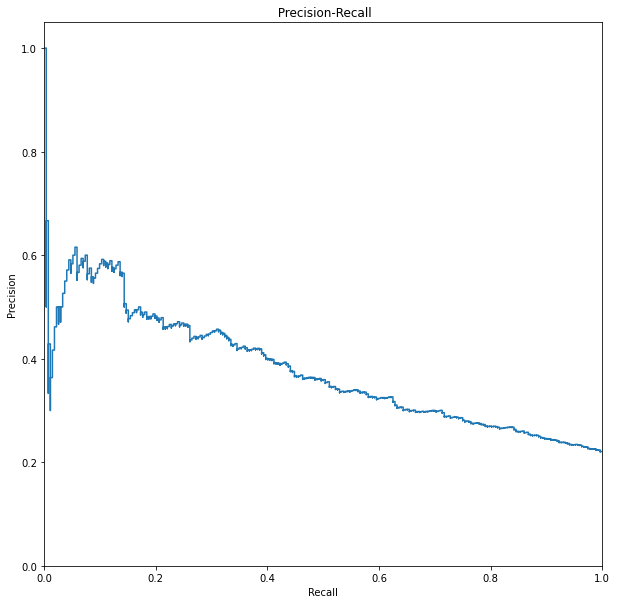

In [59]:
plt.figure(figsize=(10,10))
plt.step(recall, precision, where = 'post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(' Precision-Recall')
plt.show() 

In [60]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.15)
print(features_downsampled.shape)
print(target_downsampled.shape)

(2402, 11)
(2402,)


In [61]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.42754919499105554


In [62]:
model = DecisionTreeClassifier(random_state = 12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Accuracy = {:.3f}, Доля = {:.3f} | F1 = {:.3f}".format(
        threshold, precision, recall, f1))
    
precision, recall, threshold = precision_recall_curve(target_valid, probabilities_one_valid)

Порог = 0.00 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.05 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.10 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.15 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.20 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.25 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.30 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.35 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.40 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.45 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.50 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.55 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.60 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.65 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.70 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.75 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.513
Порог = 0.80 | Accuracy = 0.492, Доля = 0.537 | F1 = 0.5

On the logistic regression, the value has risen, but unsatisfactorily, there are no changes on the decision tree

Threshold = 0.00 | Precision = 0.236, Recall = 0.993 | F1-score = 0.381
Threshold = 0.05 | Precision = 0.296, Recall = 0.926 | F1-score = 0.449
Threshold = 0.10 | Precision = 0.372, Recall = 0.882 | F1-score = 0.523
Threshold = 0.15 | Precision = 0.421, Recall = 0.827 | F1-score = 0.558
Threshold = 0.20 | Precision = 0.455, Recall = 0.761 | F1-score = 0.569
Threshold = 0.25 | Precision = 0.509, Recall = 0.706 | F1-score = 0.592
Threshold = 0.30 | Precision = 0.547, Recall = 0.647 | F1-score = 0.593
Threshold = 0.35 | Precision = 0.581, Recall = 0.581 | F1-score = 0.581
Threshold = 0.40 | Precision = 0.622, Recall = 0.533 | F1-score = 0.574
Threshold = 0.45 | Precision = 0.650, Recall = 0.493 | F1-score = 0.561
Threshold = 0.50 | Precision = 0.674, Recall = 0.426 | F1-score = 0.523
Threshold = 0.55 | Precision = 0.688, Recall = 0.390 | F1-score = 0.498
Threshold = 0.60 | Precision = 0.744, Recall = 0.331 | F1-score = 0.458
Threshold = 0.65 | Precision = 0.771, Recall = 0.309 | F1-score 

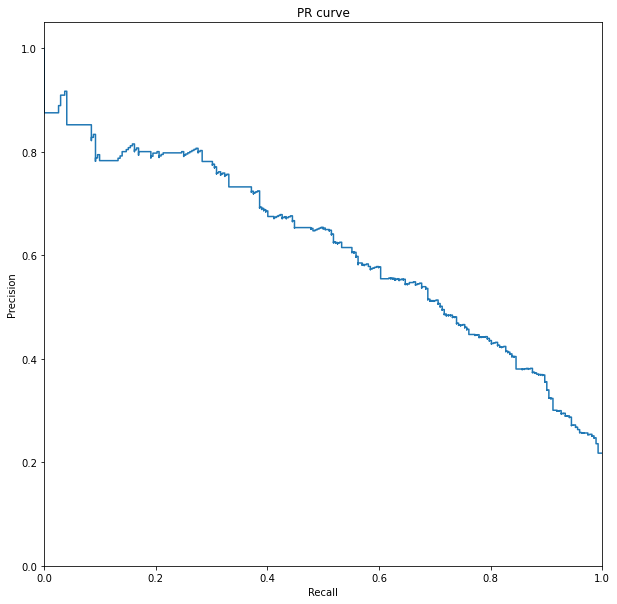

In [63]:
model = RandomForestClassifier(random_state=42, n_estimators=15,max_depth=15)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

In [64]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)
print(features_downsampled.shape)
print(target_downsampled.shape)

(3301, 11)
(3301,)


In [65]:
model =  RandomForestClassifier(random_state=42, n_estimators=15,max_depth=15)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.6036585365853657


In [66]:
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.5965463108320251


Threshold = 0.00 | Precision = 0.218, Recall = 1.000 | F1-score = 0.357
Threshold = 0.05 | Precision = 0.290, Recall = 0.963 | F1-score = 0.445
Threshold = 0.10 | Precision = 0.357, Recall = 0.901 | F1-score = 0.511
Threshold = 0.15 | Precision = 0.436, Recall = 0.835 | F1-score = 0.573
Threshold = 0.20 | Precision = 0.500, Recall = 0.754 | F1-score = 0.601
Threshold = 0.25 | Precision = 0.573, Recall = 0.710 | F1-score = 0.634
Threshold = 0.30 | Precision = 0.629, Recall = 0.629 | F1-score = 0.629
Threshold = 0.35 | Precision = 0.703, Recall = 0.592 | F1-score = 0.643
Threshold = 0.40 | Precision = 0.715, Recall = 0.489 | F1-score = 0.581
Threshold = 0.45 | Precision = 0.727, Recall = 0.441 | F1-score = 0.549
Threshold = 0.50 | Precision = 0.762, Recall = 0.412 | F1-score = 0.535
Threshold = 0.55 | Precision = 0.792, Recall = 0.379 | F1-score = 0.512
Threshold = 0.60 | Precision = 0.832, Recall = 0.346 | F1-score = 0.488
Threshold = 0.65 | Precision = 0.853, Recall = 0.298 | F1-score 

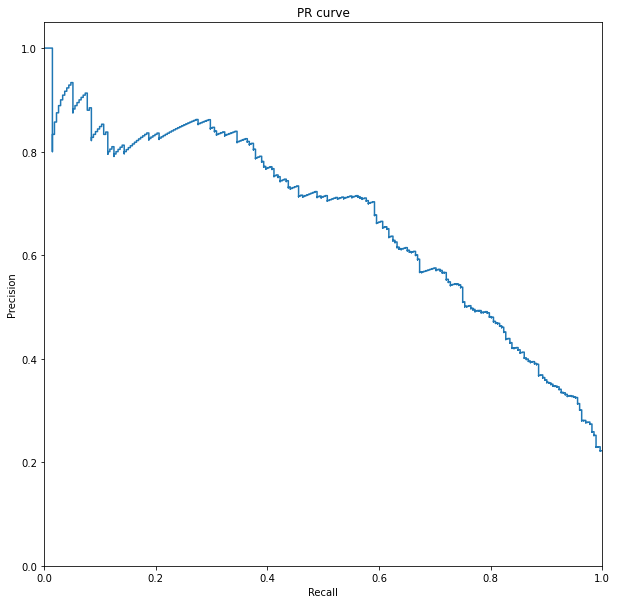

In [67]:
model = best_clf
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show()

In [68]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.35)
print(features_downsampled.shape)
print(target_downsampled.shape)

(3601, 11)
(3601,)


In [69]:
model = best_clf
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.6421725239616614


In [70]:
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.613793103448276


In [71]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(features_upsampled.shape)
print(target_upsampled.shape)

(13508, 11)
(13508,)


In [72]:
print(target_train.value_counts())
print(target_upsampled.value_counts())

0    5998
1    1502
Name: Exited, dtype: int64
1    7510
0    5998
Name: Exited, dtype: int64


In [73]:
model =  RandomForestClassifier(random_state=42, n_estimators=15,max_depth=15)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.5762711864406781


In [74]:
model_rfc = RandomForestClassifier(random_state=42, criterion='gini', 
                               min_samples_split=5, n_estimators=30
                              )
model_rfc.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.596078431372549


We have achieved a score of 0.59 on the validation sample, we can check on the test

In [75]:
best_clf=grid_search_cv_clf.best_estimator_
best_clf.score(features_train,target_train)
feature_importances = best_clf.feature_importances_
feature_importances_df=pd.DataFrame({'feature':list(features_train),
                                    'feature_importances':feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=True)

,feature,feature_importances
9,Geography_Spain,0.010709
5,HasCrCard,0.017074
10,Gender_Male,0.022128
8,Geography_Germany,0.036651
6,IsActiveMember,0.055274
2,Tenure,0.060793
0,CreditScore,0.103873
7,EstimatedSalary,0.107317
3,Balance,0.120409
4,NumOfProducts,0.172162


<AxesSubplot:xlabel='feature'>

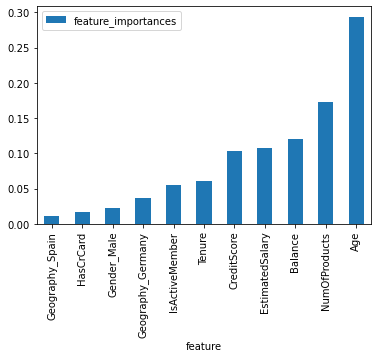

In [76]:
feature_importances_df.sort_values('feature_importances', ascending=True).plot.bar(x='feature')

In [77]:
best_model = None
best_result = 0

max_est_values = range(1, 20)
max_depth_values = range(1, 20)
min_samples_leaf = range(2,6)

for max_est in max_est_values:
    for max_depth in max_depth_values:
        for min_samples in min_samples_leaf:
            model = RandomForestClassifier(random_state=12345,criterion='entropy', n_estimators=max_est,
                                                  max_depth=max_depth, min_samples_leaf=min_samples)
            model.fit(features_train, target_train)
            probabilities_valid = model.predict_proba(features_valid) 
            probabilities_one_valid = probabilities_valid[:, 1]
            
            for threshold in np.arange(0, 0.95, 0.05):  
                predicted_valid = probabilities_one_valid > threshold
                precision = precision_score(target_valid, predicted_valid)
                recall = recall_score(target_valid, predicted_valid)
                f1 = f1_score(target_valid, predicted_valid)
                
                if precision > best_result :
                    best_model = model
                    best_result = precision
        
                if recall > best_result :
                    best_model = model
                    best_result = recall
                    
                if threshold > best_result :
                    best_model = model
                    best_result = threshold 
                    
                if f1 > best_result :
                    best_model = model
                    best_result = f1
                    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

In [78]:
predicted_valid = best_model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.20512820512820512


In [79]:
best_model = None
best_result = 0

max_est_values = range(1, 20)
max_depth_values = range(1, 20)
min_samples_leaf = range(2,6)

for max_est in max_est_values:
    for max_depth in max_depth_values:
        for min_samples in min_samples_leaf:
            model = RandomForestClassifier(random_state=12345,criterion='entropy', n_estimators=max_est,
                                                  max_depth=max_depth, min_samples_leaf=min_samples)
            model.fit(features_train, target_train)
            probabilities_valid = model.predict_proba(features_valid) 
            probabilities_one_valid = probabilities_valid[:, 1]
            for threshold in np.arange(0, 0.95, 0.05):  
                predicted_valid = probabilities_one_valid > threshold
                result = f1_score(target_valid,predicted_valid)# посчитайте качество модели на валидационной выборке
                if result > best_result:
                    best_model = model
                    best_result = result  

print('F1', best_result)

F1 0.6480263157894737


In [80]:
best_model_2 = None
best_result_2 = 0
scores_data= pd.DataFrame()
max_est_values = range(1, 40)
max_depth_values = range(1, 20)
min_samples_leaf = range(2,5)

for max_est in max_est_values:
    for max_depth in max_depth_values:
        for min_samples in min_samples_leaf:
            model = RandomForestClassifier(random_state=12345,criterion='entropy', n_estimators=max_est,
                                                  max_depth=max_depth, min_samples_leaf=min_samples)
            model.fit(features_train, target_train)
            probabilities_valid = model.predict_proba(features_valid) 
            probabilities_one_valid = probabilities_valid[:, 1]
            for threshold in np.arange(0, 0.95, 0.05):  
                predicted_valid = probabilities_one_valid > threshold
                result = f1_score(target_valid,predicted_valid)
                temp_score_data=pd.DataFrame({'max_est' : [max_est], 'max_depth' : [max_depth],
                                              'min_samples_leaf': [min_samples_leaf],'threshold': [threshold],
                                              'f1': [result]})
                scores_data=scores_data.append(temp_score_data)

                if result > best_result:
                    best_model_2 = model
                    best_result_2 = result  

print('F1', best_result_2)

F1 0.6482504604051565


In [81]:
scores_data.sort_values('f1', ascending = False).head()

,max_est,max_depth,min_samples_leaf,threshold,f1
0,31,10,"(2, 3, 4)",0.30,0.654412
0,39,8,"(2, 3, 4)",0.25,0.652529
0,28,10,"(2, 3, 4)",0.30,0.652095
0,38,8,"(2, 3, 4)",0.25,0.651391
0,23,8,"(2, 3, 4)",0.25,0.651391


In [82]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)
print(features_downsampled.shape)
print(target_downsampled.shape)

(3301, 11)
(3301,)


In [83]:
model =  RandomForestClassifier(random_state=12345,criterion='entropy', n_estimators=31,
                                                  max_depth=10, min_samples_leaf=2)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.6283048211508554


## Testing the model

In [84]:
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.6392092257001648


In [85]:
conf_matrix = confusion_matrix(target_test, predicted_test)
print(conf_matrix)

[[837 150]
 [ 69 194]]


In [86]:
%%time
accuracy = accuracy_score(target_test, predicted_test)
precision = precision_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.8248
Precision: 0.563953488372093
Recall: 0.7376425855513308
F1: 0.6392092257001648
Wall time: 8.58 ms


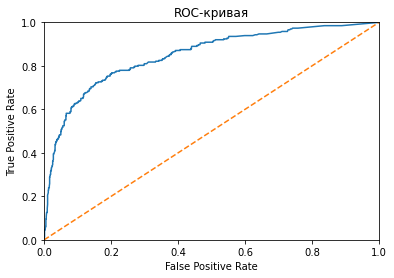

In [87]:
probabilities = model_rfc.predict_proba(features_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(target_test, probabilities)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [88]:
auc_roc = roc_auc_score(target_test, probabilities)
print('AUC:',auc_roc)

AUC: 0.848634915498438


In [89]:
from sklearn import preprocessing

In [90]:
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']
features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

In [93]:
scaler = preprocessing.StandardScaler()

In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras
 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [94]:
from keras import models
from keras import layers

In [97]:
import keras

In [100]:
model = keras.Sequential([
    Dense(128, activation='relu'),
    Dense(10, activation='softmax') 
])

In [102]:
network = model

In [103]:
network.add(layers.Dense(units=16, activation = 'relu', input_shape=(10,)))

In [104]:
network.add(layers.Dense(units=16, activation = 'relu'))

In [105]:
network.add(layers.Dense(units=16, activation = 'sigmoid'))

In [108]:
history= network.fit(
features_train,
target_train, 
epochs = 3,
verbose = 1,
batch_size = 100,
validation_data=(features_test,target_test))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [111]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings

In [112]:
scaler = MinMaxScaler()
#fit the training datatset
scaler.fit(features_train)

#transform train and test sets
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [114]:
X = data_ohe.drop("Exited",axis=1)
y = data_ohe["Exited"]

In [115]:
model = keras.Sequential([
    
    keras.layers.Dense(32,input_shape=(X.shape[1],)),
    keras.layers.Activation(tf.nn.relu),
    
    keras.layers.Dense(16),
    keras.layers.Activation(tf.nn.relu),

    keras.layers.Dense(8),
    keras.layers.Activation(tf.nn.relu),
    
    keras.layers.Dense(1),
    keras.layers.Activation(tf.nn.sigmoid)
])

In [116]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [118]:
history = model.fit(features_train,target_train,validation_data=(features_test,target_test),epochs=15,batch_size=32)

Epoch 1/15
235/235 [==============================] - 2s 4ms/step - loss: 0.5431 - accuracy: 0.7997 - val_loss: 0.5123 - val_accuracy: 0.7896
Epoch 2/15
235/235 [==============================] - 1s 2ms/step - loss: 0.4867 - accuracy: 0.7997 - val_loss: 0.4945 - val_accuracy: 0.7896
Epoch 3/15
235/235 [==============================] - 0s 2ms/step - loss: 0.4755 - accuracy: 0.7997 - val_loss: 0.4887 - val_accuracy: 0.7896
Epoch 4/15
235/235 [==============================] - 0s 1ms/step - loss: 0.4697 - accuracy: 0.7997 - val_loss: 0.4835 - val_accuracy: 0.7896
Epoch 5/15
235/235 [==============================] - 0s 1ms/step - loss: 0.4655 - accuracy: 0.7997 - val_loss: 0.4803 - val_accuracy: 0.7896
Epoch 6/15
235/235 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.7997 - val_loss: 0.4765 - val_accuracy: 0.7896
Epoch 7/15
235/235 [==============================] - 0s 2ms/step - loss: 0.4594 - accuracy: 0.7997 - val_loss: 0.4739 - val_accuracy: 0.7896
Epoch 

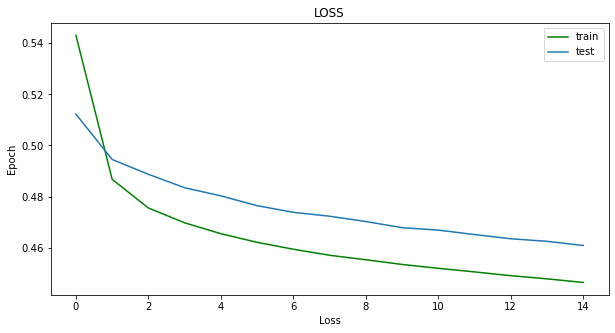

In [119]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label='train',color='g')
plt.plot(history.history['val_loss'],label='test')
plt.title('LOSS')
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()
plt.show()

In [122]:
y_pred_ = model.predict(features_test)
y_pred = []
for target in y_pred_:
    if target > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Classification report: \n", classification_report(target_test,y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       987
           1       0.00      0.00      0.00       263

    accuracy                           0.79      1250
   macro avg       0.39      0.50      0.44      1250
weighted avg       0.62      0.79      0.70      1250



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


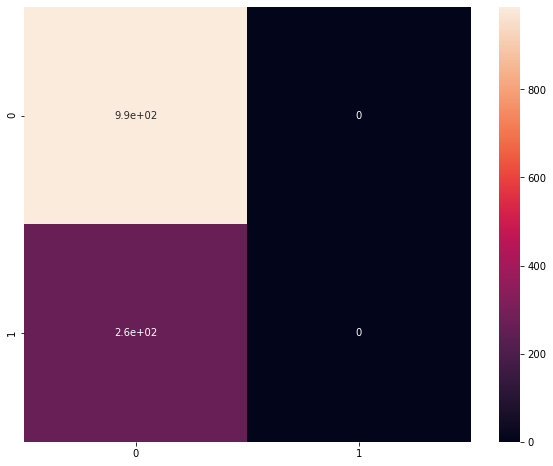

In [124]:
cm = confusion_matrix(target_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True)
plt.show()

In [125]:
accuracy_score(target_test,y_pred)

0.7896